In [1]:
# Εγκατάσταση των βιβλιοθηκών numpy (για αριθμητικούς υπολογισμούς), pandas (για επεξεργασία δεδομένων),
# matplotlib και seaborn (για οπτικοποίηση δεδομένων), scikit-learn (για machine learning) και torch (για deep learning)
# Οι βιβλιοθήκες είναι ήδη εγκατεστημένες στο περιβάλλον και δεν χρειάζεται να τις ξαναεγκαταστήσουμε.
# Αν κάποιος τρέξει το notebook σε νέο περιβάλλον, θα χρειαστεί να εκτελέσει την εξής εντολή για να εγκαταστήσει τις βιβλιοθήκες:
# !pip install numpy pandas matplotlib seaborn scikit-learn torch

In [61]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών

import torch # για deep learning
import numpy as np # για αριθμητικούς υπολογισμούς
import torch.nn as nn # για νευρωνικά δίκτυα
import torch.optim as optim # για βελτιστοποίηση
from torch.utils.data import DataLoader, TensorDataset # για διαχείριση δεδομένων
import matplotlib.pyplot as plt # για οπτικοποίηση δεδομένων
import seaborn as sns # για οπτικοποίηση δεδομένων
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score  # για αξιολόγηση μοντέλου
from sklearn.preprocessing import label_binarize # για μετατροπή ετικετών σε δυαδική μορφή
from sklearn.preprocessing import LabelEncoder # για μετατροπή ετικετών σε αριθμητικές τιμές



In [62]:
# Ορισμός του seed για αναπαραγωγιμότητα
seed = 42
random.seed(seed)  # Για τη βιβλιοθήκη random
np.random.seed(seed)  # Για τη βιβλιοθήκη NumPy

# Για PyTorch, αν το χρησιμοποιείς:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Σε πολλαπλές GPU αν υπάρχουν

# Ρυθμίσεις για αναπαραγωγιμότητα με GPU
torch.backends.cudnn.deterministic = True  # Αναγκάζει ντετερμινιστικές πράξεις
torch.backends.cudnn.benchmark = False  # Απενεργοποιεί το benchmarking για τα βελτιστοποιημένα μεγέθη μπλοκ

# Ελέγχουμε εάν το seed έχει ρυθμιστεί σωστά
print(f"Random seed set to {seed}")

Random seed set to 42


In [63]:
# Ελέγχουμε αν υπάρχει GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρησιμοποιούμε τη συσκευή: {device}")

Χρησιμοποιούμε τη συσκευή: cuda


In [64]:
# Φορτώνουμε τα δεδομένα από το αρχείο που αποθηκεύσαμε

data = np.load('train_test_images_normalized_images.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']  # Φόρτωση των ονομάτων των κατηγοριών

# Εκτύπωση των σχημάτων και των ονομάτων των κατηγοριών
print(f"Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: {X_train.shape}, ετικέτες: {y_train.shape}")
print(f"Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: {X_test.shape}, ετικέτες: {y_test.shape}")
print(f"Ονόματα Κατηγοριών: {class_names}")

Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: (2800, 4096), ετικέτες: (2800,)
Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: (1200, 4096), ετικέτες: (1200,)
Ονόματα Κατηγοριών: ['BreastMRI' 'ChestCT' 'CXR' 'Hand']


In [65]:
# Μετατροπή των ετικετών σε κατηγορίες 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Μετατροπή των δεδομένων σε PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:")
print(f"X_train: {X_train_tensor.shape}, X_test: {X_test_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}, y_test: {y_test_tensor.shape}")

Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:
X_train: torch.Size([2800, 4096]), X_test: torch.Size([1200, 4096])
y_train: torch.Size([2800]), y_test: torch.Size([1200])


Για την αρχιτεκτονική του MLP επιλέξαμε τρία κρυφά επίπεδα με 512, 256 και 128 νευρώνες, προκειμένου το μοντέλο να μπορεί να μάθει σύνθετες σχέσεις στα δεδομένα, χωρίς να είναι υπερβολικά μεγάλο και αργό. Χρησιμοποιήσαμε τη συνάρτηση ενεργοποίησης ReLU για να αποφύγουμε το πρόβλημα του vanishing gradient και προσθέσαμε Dropout (50%) για να μειώσουμε την υπερπροσαρμογή και να βελτιώσουμε τη γενίκευση του μοντέλου. Επίσης, ενεργοποιήσαμε το Batch Normalization για πιο γρήγορη και σταθερή εκπαίδευση. Το μοντέλο εκπαιδεύτηκε για 20 εποχές με Adam optimizer και L2 regularization για καλύτερη απόδοση και αποφυγή υπερβολικής προσαρμογής στις ειδικές περιπτώσεις του training set.

In [56]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.0, use_batchnorm=False):
        super(MLP, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.layers = nn.ModuleList()  # Αρχικοποιούμε τη λίστα των layers
        in_size = input_size
        
        # Δημιουργία των κρυφών επιπέδων
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))  # Πρόσθεση Linear Layer
            if self.use_batchnorm: 
                self.layers.append(nn.BatchNorm1d(hidden_size))  # Πρόσθεση Batch Normalization (αν το ζητήσουμε)
            self.layers.append(nn.ReLU())  # Συναρτήσεις ενεργοποίησης ReLU
            self.layers.append(nn.Dropout(dropout_rate))  # Πρόσθεση Dropout για κανονικοποίηση
            in_size = hidden_size  # Ορίζουμε το in_size για το επόμενο επίπεδο

        # Εξοδος
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Προώθηση μέσω των layers
        for layer in self.layers:
            x = layer(x)
        
        # Προώθηση μέσω του τελευταίου επιπέδου (output layer)
        x = self.output(x)
        
        return x

Epoch [1/20], Loss: 1.5047, Train Accuracy: 26.36%, Test Accuracy: 96.25%
Epoch [2/20], Loss: 0.9106, Train Accuracy: 71.36%, Test Accuracy: 97.33%
Epoch [3/20], Loss: 0.6762, Train Accuracy: 88.89%, Test Accuracy: 97.58%
Epoch [4/20], Loss: 0.5299, Train Accuracy: 94.32%, Test Accuracy: 97.92%
Epoch [5/20], Loss: 0.4270, Train Accuracy: 96.11%, Test Accuracy: 98.00%
Epoch [6/20], Loss: 0.3563, Train Accuracy: 96.96%, Test Accuracy: 98.00%
Epoch [7/20], Loss: 0.3082, Train Accuracy: 97.36%, Test Accuracy: 98.25%
Epoch [8/20], Loss: 0.2712, Train Accuracy: 97.50%, Test Accuracy: 98.25%
Epoch [9/20], Loss: 0.2356, Train Accuracy: 97.46%, Test Accuracy: 98.25%
Epoch [10/20], Loss: 0.2157, Train Accuracy: 97.75%, Test Accuracy: 98.17%
Epoch [11/20], Loss: 0.1929, Train Accuracy: 97.61%, Test Accuracy: 98.25%
Epoch [12/20], Loss: 0.1730, Train Accuracy: 97.86%, Test Accuracy: 98.25%
Epoch [13/20], Loss: 0.1581, Train Accuracy: 98.18%, Test Accuracy: 98.25%
Epoch [14/20], Loss: 0.1506, Train

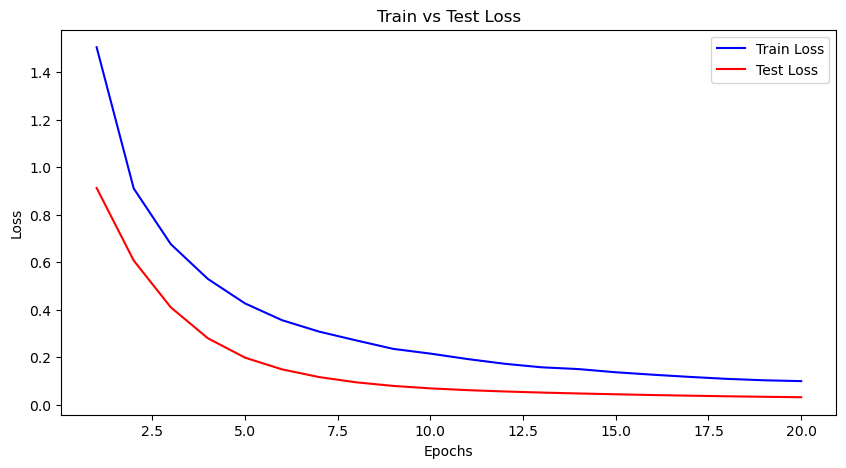

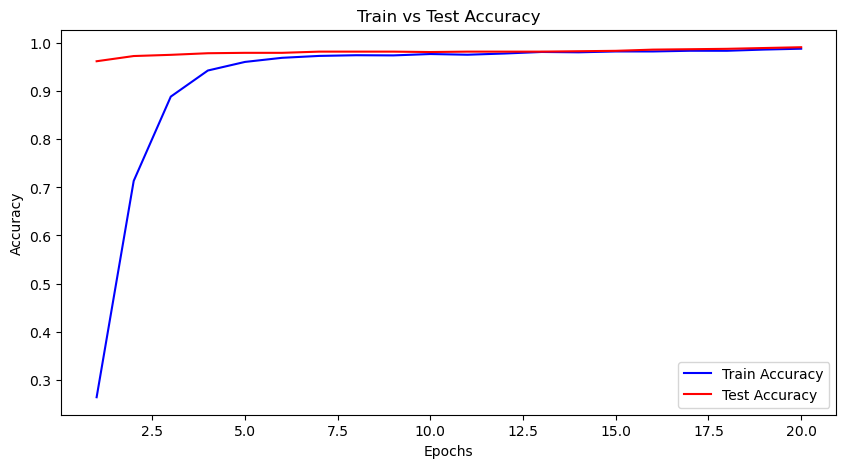

Test Accuracy: 99.17%

Classification Report:
              precision    recall  f1-score   support

   BreastMRI       0.99      1.00      1.00       300
     ChestCT       0.99      0.99      0.99       300
         CXR       0.99      1.00      1.00       300
        Hand       0.99      0.98      0.98       300

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



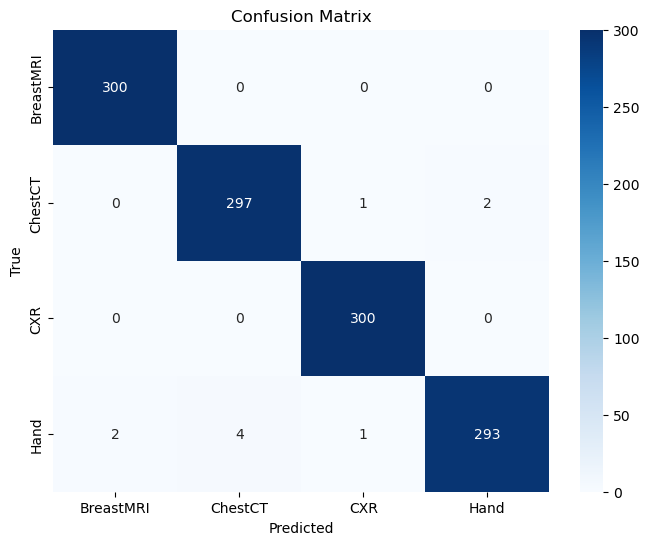

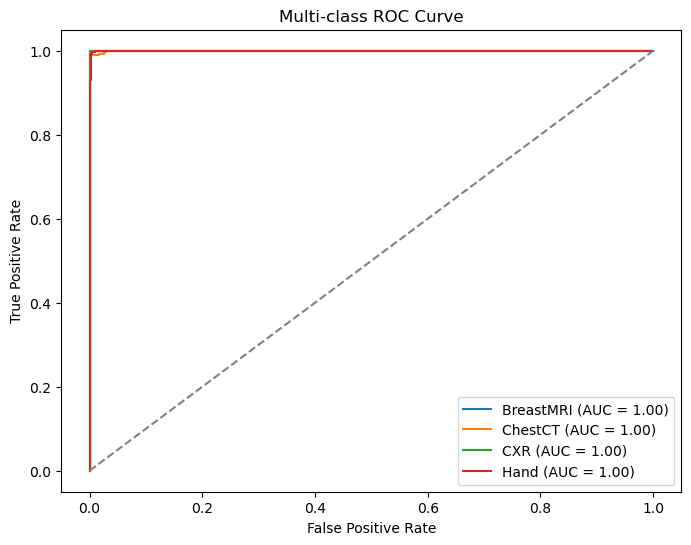

In [57]:
# Ορισμός υπερπαραμέτρων
input_size = X_train_tensor.shape[1]  # 4096
hidden_sizes = [512, 256, 128]  # Μπορούμε να προσαρμόσουμε τα μεγέθη των κρυφών επιπέδων
output_size = len(np.unique(y_train))  # Ο αριθμός των κατηγοριών
dropout_rate = 0.5
use_batchnorm = True

# Δημιουργία του μοντέλου
model = MLP(input_size, hidden_sizes, output_size, dropout_rate, use_batchnorm).to(device)

# Ορισμός του Loss Function και του Optimizer
criterion = nn.CrossEntropyLoss()  # Χρησιμοποιούμε το CrossEntropyLoss για ταξινόμηση
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Αριθμός εποχών
num_epochs = 20

# Αρχικοποίηση των λιστών για την καταγραφή της απώλειας και της ακρίβειας
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Εκπαίδευση του μοντέλου
for epoch in range(1, num_epochs + 1):
    model.train()  # Θέτουμε το μοντέλο σε training mode
    optimizer.zero_grad()  # Μηδενίζουμε τους παραμέτρους του βελτιστοποιητή
    
    # Forward Pass για το train set
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    
    # Backward Pass και Βελτιστοποίηση
    loss_train.backward()
    optimizer.step()
    
    # Υπολογισμός της ακρίβειας για το train set
    _, predicted_train = torch.max(outputs_train, 1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted_train.cpu())
    
    # Αξιολόγηση στο test set
    model.eval()  # Θέτουμε το μοντέλο σε evaluation mode
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        loss_test = criterion(outputs_test, y_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_test.cpu())
    
    # Καταγραφή των τιμών του loss και accuracy
    train_losses.append(loss_train.item())
    train_accuracies.append(train_accuracy)
    test_losses.append(loss_test.item())
    test_accuracies.append(test_accuracy)
    
    # Εκτύπωση της πρόοδου κάθε epoch
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss_train.item():.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

# Οπτικοποίηση των Loss και Accuracy για Train και Test
# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Αξιολόγηση του μοντέλου στο test set
model.eval()  # Θέτουμε το μοντέλο σε evaluation mode
with torch.no_grad():
    outputs_test = model(X_test_tensor)  # Εκτιμούμε το test set
    _, predicted_test = torch.max(outputs_test, 1)  # Παίρνουμε τις προβλέψεις
    
    # Υπολογισμός της ακρίβειας για το test set
    test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_test.cpu())
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted_test.cpu(), target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor.cpu(), predicted_test.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve - Multi-class ROC Curve
    y_test_bin = label_binarize(y_test_tensor.cpu(), classes=np.arange(len(class_names)))
    outputs_test_softmax = outputs_test.softmax(dim=1).cpu().numpy()  # Softmax για την εκτίμηση των πιθανοτήτων
    
    # Υπολογισμός του ROC Curve για κάθε κατηγορία
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], outputs_test_softmax[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plotting ROC Curve για κάθε κατηγορία
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Ακολουθούν ακόμη κάποιοι πειραματισμοί με διαφορετικές υπερπαραμέτρους (ρυθμός μάθησης-learning rate, αριθμός επιπέδων και νευρώνων, συναρτήσεις ενεργοποίησης) και τεχνικές κανονικοποίησης και regularization.

Epoch [1/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 1.5074 | Train Accuracy: 17.36% Test Accuracy: 89.50%
Epoch [2/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 0.4053 | Train Accuracy: 95.04% Test Accuracy: 97.75%
Epoch [3/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 0.2184 | Train Accuracy: 97.18% Test Accuracy: 98.17%
Epoch [4/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 0.1537 | Train Accuracy: 97.57% Test Accuracy: 98.17%
Epoch [5/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 0.1204 | Train Accuracy: 97.86% Test Accuracy: 98.17%
Epoch [6/20] | Hidden: [512, 256] | Dropout: 0.2 | BatchNorm: True | Activation: ReLU | LR: 0.001 Train Loss: 0.1000 | Train Accuracy: 97.96% Test Accuracy: 98.33%
Epoch [7/20] | H

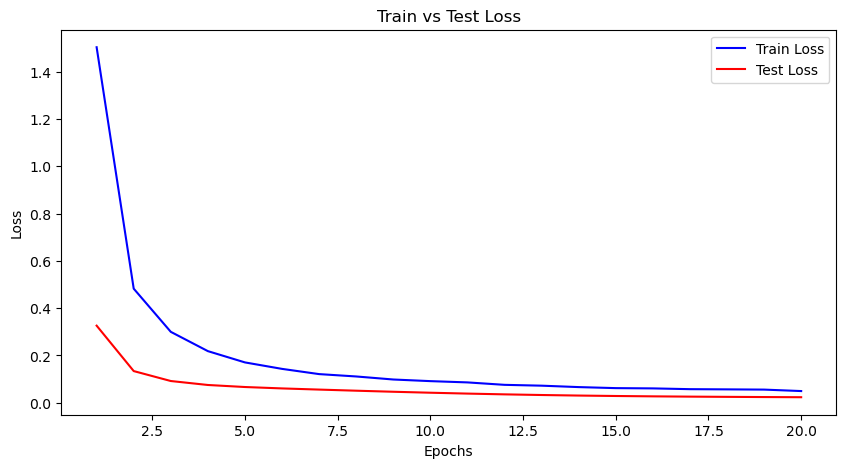

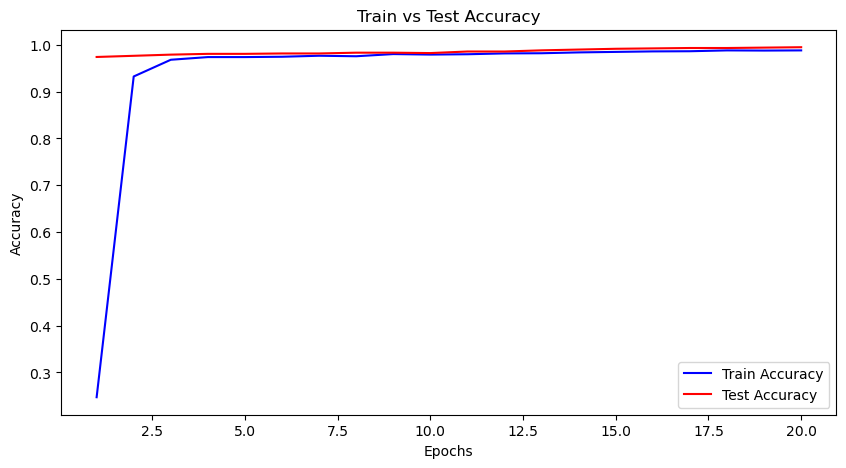

Test Accuracy: 99.50%

Classification Report:
              precision    recall  f1-score   support

   BreastMRI       0.99      1.00      1.00       300
     ChestCT       1.00      0.99      0.99       300
         CXR       1.00      1.00      1.00       300
        Hand       0.99      0.99      0.99       300

    accuracy                           0.99      1200
   macro avg       1.00      0.99      0.99      1200
weighted avg       1.00      0.99      0.99      1200



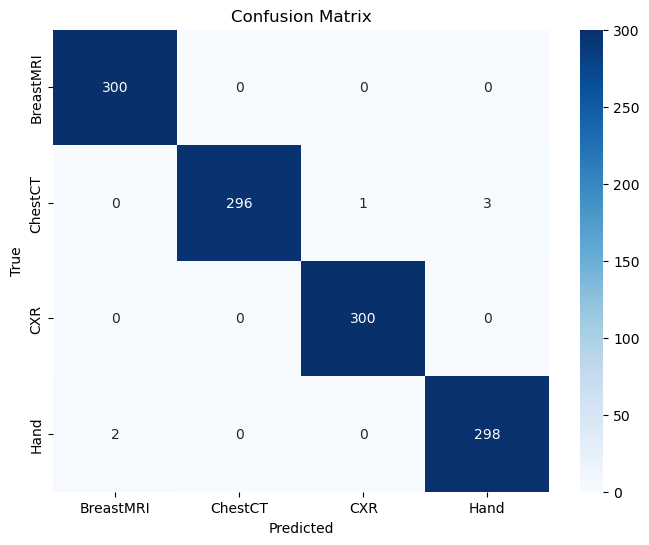

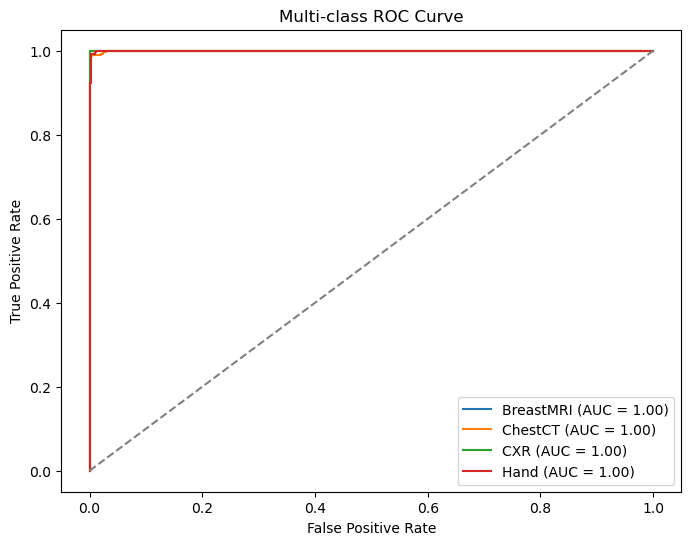

In [66]:
# Υλοποίηση του MLP για πειραματισμό με διαφορετικές υπερπαραμέτρους
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.0, use_batchnorm=False, activation_fn=nn.ReLU):
        super(MLP, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.layers = nn.ModuleList()  # Αρχικοποιούμε τη λίστα των layers
        in_size = input_size
        
        # Δημιουργία των κρυφών επιπέδων
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))  # Πρόσθεση Linear Layer
            if self.use_batchnorm: 
                self.layers.append(nn.BatchNorm1d(hidden_size))  # Πρόσθεση Batch Normalization (αν το ζητήσουμε)
            self.layers.append(activation_fn())  # Συναρτήσεις ενεργοποίησης (π.χ. ReLU, Sigmoid, Tanh)
            self.layers.append(nn.Dropout(dropout_rate))  # Πρόσθεση Dropout για κανονικοποίηση
            in_size = hidden_size  # Ορίζουμε το in_size για το επόμενο επίπεδο

        # Εξοδος
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Προώθηση μέσω των layers
        for layer in self.layers:
            x = layer(x)
        
        # Προώθηση μέσω του τελευταίου επιπέδου (output layer)
        x = self.output(x)
        
        return x

# Ρυθμίσεις υπερπαραμέτρων για πειραματισμό
input_size = X_train_tensor.shape[1]  # 4096
hidden_sizes = [[512, 256], [512, 256, 128], [1024, 512]]  # Πειραματισμός με διαφορετικά μεγέθη
output_size = len(np.unique(y_train))  # Ο αριθμός των κατηγοριών
dropout_rates = [0.2, 0.5, 0.8]  # Πειραματισμός με διαφορετικούς ρυθμούς dropout
batchnorm_options = [True, False]  # Χρήση ή όχι Batch Normalization
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh]  # Πειραματισμός με διαφορετικές συναρτήσεις ενεργοποίησης
learning_rates = [0.001, 0.01, 0.0001]  # Πειραματισμός με διαφορετικούς ρυθμούς μάθησης

# Ορισμός του Loss Function
criterion = nn.CrossEntropyLoss()

# Αρχικοποίηση των λιστών για την καταγραφή της απώλειας και της ακρίβειας
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Αποθήκευση των καλύτερων υπερπαραμέτρων και της αντίστοιχης ακρίβειας
best_accuracy = 0
best_hyperparams = {}

# Εκπαίδευση και αξιολόγηση για κάθε συνδυασμό υπερπαραμέτρων
for hidden_size in hidden_sizes:
    for dropout_rate in dropout_rates:
        for use_batchnorm in batchnorm_options:
            for activation_fn in activation_functions:
                for lr in learning_rates:
                    # Δημιουργία του μοντέλου με τις τρέχουσες υπερπαράμετρους
                    model = MLP(input_size, hidden_size, output_size, dropout_rate, use_batchnorm, activation_fn).to(device)

                    # Ορισμός του Optimizer
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Εκπαίδευση του μοντέλου για 20 εποχές
                    for epoch in range(1, 21):
                        model.train()  # Θέτουμε το μοντέλο σε training mode
                        optimizer.zero_grad()  # Μηδενίζουμε τους παραμέτρους του βελτιστοποιητή

                        # Forward Pass για το train set
                        outputs_train = model(X_train_tensor)
                        loss_train = criterion(outputs_train, y_train_tensor)

                        # Backward Pass και Βελτιστοποίηση
                        loss_train.backward()
                        optimizer.step()

                        # Υπολογισμός της ακρίβειας για το train set
                        _, predicted_train = torch.max(outputs_train, 1)
                        train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted_train.cpu())

                        # Αξιολόγηση στο test set
                        model.eval()  # Θέτουμε το μοντέλο σε evaluation mode
                        with torch.no_grad():
                            outputs_test = model(X_test_tensor)
                            loss_test = criterion(outputs_test, y_test_tensor)
                            _, predicted_test = torch.max(outputs_test, 1)
                            test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_test.cpu())

                        # Καταγραφή των τιμών του loss και accuracy
                        train_losses.append(loss_train.item())
                        train_accuracies.append(train_accuracy)
                        test_losses.append(loss_test.item())
                        test_accuracies.append(test_accuracy)

                        # Εκτύπωση της πρόοδου κάθε epoch
                        print(f"Epoch [{epoch}/20] | Hidden: {hidden_size} | Dropout: {dropout_rate} | "
                              f"BatchNorm: {use_batchnorm} | Activation: {activation_fn.__name__} | LR: {lr} "
                              f"Train Loss: {loss_train.item():.4f} | Train Accuracy: {train_accuracy*100:.2f}% "
                              f"Test Accuracy: {test_accuracy*100:.2f}%")

                    # Ελέγχουμε αν η τρέχουσα ακρίβεια στο test set είναι καλύτερη από την καλύτερη
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_hyperparams = {
                            "hidden_sizes": hidden_size,
                            "dropout_rate": dropout_rate,
                            "batchnorm": use_batchnorm,
                            "activation_fn": activation_fn.__name__,
                            "learning_rate": lr
                        }

# Εκτύπωση των καλύτερων υπερπαραμέτρων και της αντίστοιχης ακρίβειας
print("\nBest Model Hyperparameters:")
print(f"Hidden Layers: {best_hyperparams['hidden_sizes']}")
print(f"Dropout Rate: {best_hyperparams['dropout_rate']}")
print(f"Batch Normalization: {best_hyperparams['batchnorm']}")
print(f"Activation Function: {best_hyperparams['activation_fn']}")
print(f"Learning Rate: {best_hyperparams['learning_rate']}")
print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")

# Εκπαίδευση και αξιολόγηση για το καλύτερο μοντέλο με τα βέλτιστα υπερπαραμέτρους
train_losses_best = []
train_accuracies_best = []
test_losses_best = []
test_accuracies_best = []

# Δημιουργία του μοντέλου με τις καλύτερες υπερπαράμετρους
model_best = MLP(input_size, best_hyperparams["hidden_sizes"], output_size,
                 best_hyperparams["dropout_rate"], best_hyperparams["batchnorm"],
                 activation_fn=eval(f"nn.{best_hyperparams['activation_fn']}")).to(device)

optimizer_best = optim.Adam(model_best.parameters(), lr=best_hyperparams["learning_rate"])

# Εκπαίδευση του καλύτερου μοντέλου για 20 εποχές
for epoch in range(1, 21):
    model_best.train()  # Θέτουμε το μοντέλο σε training mode
    optimizer_best.zero_grad()  # Μηδενίζουμε τους παραμέτρους του βελτιστοποιητή

    # Forward Pass για το train set
    outputs_train_best = model_best(X_train_tensor)
    loss_train_best = criterion(outputs_train_best, y_train_tensor)

    # Backward Pass και Βελτιστοποίηση
    loss_train_best.backward()
    optimizer_best.step()

    # Υπολογισμός της ακρίβειας για το train set
    _, predicted_train_best = torch.max(outputs_train_best, 1)
    train_accuracy_best = accuracy_score(y_train_tensor.cpu(), predicted_train_best.cpu())

    # Αξιολόγηση στο test set
    model_best.eval()  # Θέτουμε το μοντέλο σε evaluation mode
    with torch.no_grad():
        outputs_test_best = model_best(X_test_tensor)
        loss_test_best = criterion(outputs_test_best, y_test_tensor)
        _, predicted_test_best = torch.max(outputs_test_best, 1)
        test_accuracy_best = accuracy_score(y_test_tensor.cpu(), predicted_test_best.cpu())

    # Καταγραφή των τιμών του loss και accuracy
    train_losses_best.append(loss_train_best.item())
    train_accuracies_best.append(train_accuracy_best)
    test_losses_best.append(loss_test_best.item())
    test_accuracies_best.append(test_accuracy_best)

    # Εκτύπωση της πρόοδου κάθε epoch
    print(f"Epoch [{epoch}/20] | Hidden: {best_hyperparams['hidden_sizes']} | Dropout: {best_hyperparams['dropout_rate']} | "
          f"BatchNorm: {best_hyperparams['batchnorm']} | Activation: {best_hyperparams['activation_fn']} | LR: {best_hyperparams['learning_rate']} "
          f"Train Loss: {loss_train_best.item():.4f} | Train Accuracy: {train_accuracy_best*100:.2f}% "
          f"Test Accuracy: {test_accuracy_best*100:.2f}%")

# Οπτικοποίηση των Loss και Accuracy για Train και Test
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), train_losses_best, label='Train Loss', color='blue')
plt.plot(range(1, 21), test_losses_best, label='Test Loss', color='red')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), train_accuracies_best, label='Train Accuracy', color='blue')
plt.plot(range(1, 21), test_accuracies_best, label='Test Accuracy', color='red')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Αξιολόγηση του μοντέλου στο test set
model_best.eval()  # Θέτουμε το μοντέλο σε evaluation mode
with torch.no_grad():
    outputs_test_best = model_best(X_test_tensor)  # Εκτιμούμε το test set
    _, predicted_test_best = torch.max(outputs_test_best, 1)  # Παίρνουμε τις προβλέψεις

    # Υπολογισμός της ακρίβειας για το test set
    test_accuracy_best = accuracy_score(y_test_tensor.cpu(), predicted_test_best.cpu())
    print(f'Test Accuracy: {test_accuracy_best * 100:.2f}%')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted_test_best.cpu(), target_names=class_names))

    # Confusion Matrix
    cm_best = confusion_matrix(y_test_tensor.cpu(), predicted_test_best.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve - Multi-class ROC Curve
    y_test_bin_best = label_binarize(y_test_tensor.cpu(), classes=np.arange(len(class_names)))
    outputs_test_best_softmax = outputs_test_best.softmax(dim=1).cpu().numpy()  # Softmax για την εκτίμηση των πιθανοτήτων

    # Υπολογισμός του ROC Curve για κάθε κατηγορία
    fpr_best, tpr_best, roc_auc_best = {}, {}, {}
    for i in range(len(class_names)):
        fpr_best[i], tpr_best[i], _ = roc_curve(y_test_bin_best[:, i], outputs_test_best_softmax[:, i])
        roc_auc_best[i] = auc(fpr_best[i], tpr_best[i])

    # Plotting ROC Curve για κάθε κατηγορία
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr_best[i], tpr_best[i], label=f'{class_names[i]} (AUC = {roc_auc_best[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()